In [1]:
import os
import random
from typing import Optional

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
from sklearn import preprocessing, model_selection, metrics

In [4]:
from tensorflow import keras

keras.backend.clear_session()

In [5]:
RANDOM_SEED = 42

In [6]:
root_img_dir = "./datasets/images"

original_img_dir = f"{root_img_dir}/original"
train_img_dir = f"{root_img_dir}/train"
test_img_dir = f"{root_img_dir}/test"
val_img_dir = f"{root_img_dir}/val"

numpy_img_dir = "./datasets/numpy/images.npy"
numpy_label_dir = "./datasets/numpy/labels.npy"

In [7]:
path_to_model = "artifacts/models/model_guided_pruning.h5"

In [8]:
def load_and_transform_images():
    if os.path.exists(numpy_img_dir) and os.path.exists(numpy_label_dir):
        print("Files already exist, skipping...")
        return

    categories = os.listdir(original_img_dir)

    images = []
    labels = []

    for category in categories:
        image_files = os.listdir(os.path.join(original_img_dir, category))

        for image_file in image_files:
            img = keras.preprocessing.image.load_img(
                os.path.join(original_img_dir, category, image_file), target_size=(256, 256)
            )
            img = keras.preprocessing.image.img_to_array(img)
            img = img / 255.0

            images.append(img)
            labels.append(category)

    images = np.array(images)
    labels = np.array(labels)

    np.save(numpy_img_dir, images)
    np.save(numpy_label_dir, labels)


load_and_transform_images()

Files already exist, skipping...


In [9]:
images = np.load(numpy_img_dir)
labels = np.load(numpy_label_dir)

In [10]:
num_classes = len(np.unique(labels))

In [11]:
le = preprocessing.LabelEncoder()

labels = le.fit_transform(labels)

labels = keras.utils.to_categorical(labels, num_classes)

In [12]:
X_train_val, X_test, Y_train_val, Y_test = model_selection.train_test_split(
    images, labels, test_size=1 / 8, random_state=RANDOM_SEED
)

X_train, X_val, Y_train, Y_val = model_selection.train_test_split(
    X_train_val, Y_train_val, test_size=1 / 20, random_state=RANDOM_SEED
)

In [13]:
def build_model(
    num_conv_layers: int, kernel_sizes: list[tuple[int, int]], conv_filters: list[int], dense_units: int, num_dense: int
):
    conv_layers = [
        [
            keras.layers.Conv2D(
                filters=conv_filters[i],
                kernel_size=kernel_size,
                activation="relu",
                input_shape=images.shape[1:],
            )
            if i == 0
            else keras.layers.Conv2D(
                filters=conv_filters[i],
                kernel_size=kernel_size,
                activation="relu",
            ),
            keras.layers.MaxPooling2D(pool_size=(2, 2)),
            keras.layers.Dropout(0.5),
            keras.layers.BatchNormalization() if i != len(kernel_sizes) - 1 else keras.layers.Flatten(),
        ]
        for i, kernel_size in enumerate(kernel_sizes)
    ]

    dense_layers = [
        [keras.layers.Dense(units=dense_units, activation="relu"), keras.layers.Dropout(0.5)] for _ in range(num_dense)
    ]

    layers = (
        [layer for conv_layer in conv_layers for layer in conv_layer]
        + [layer for dense_layer in dense_layers for layer in dense_layer]
        + [keras.layers.Dense(units=num_classes, activation="softmax")]
    )

    model = keras.models.Sequential(layers=layers)

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [14]:
def train_and_test(model: keras.models.Sequential):
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)

    history = model.fit(
        X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, batch_size=500, callbacks=[early_stopping]
    )

    loss, accuracy = model.evaluate(X_test, Y_test)

    return history, loss, accuracy

In [15]:
def plot_accuracy(history: keras.callbacks.History):
    plt.plot(history.history["accuracy"], label="train accuracy")
    plt.plot(history.history["val_accuracy"], label="validation accuracy")
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(loc="best")
    plt.savefig("artifacts/plots/Accuracy_GuidedPruning")
    plt.show()


def plot_loss(history: keras.callbacks.History):
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(loc="best")
    plt.savefig("artifacts/plots/Loss_GuidedPruning")
    plt.show()

In [16]:
def guided_pruning():
    params = {
        "num_conv_layers": 3,
        "kernel_sizes": [(11, 11), (5, 5), (3, 3)],
        "conv_filters": [3, 16, 96],
        "dense_units": 2048,
        "num_dense": 2,
    }

    goal_acc = 0.9
    accuracy = 0.0
    best_acc = 0
    best_loss = 0
    best_params = params.copy()
    best_history: Optional[keras.callbacks.History] = None
    best_model: Optional[keras.models.Model] = None

    for _ in range(3):  # Limiting to 3 iterations due to OOM error
        if accuracy > goal_acc:
            break

        key = random.choice(list(params.keys()))
        if key == "num_conv_layers":
            num = random.choice([-1, 1])
            if num == -1:
                params["num_conv_layers"] -= 1
                params["kernel_sizes"].pop()
                params["conv_filters"].pop()
            else:
                params["num_conv_layers"] += 1
                params["kernel_sizes"].append((3, 3))
                params["conv_filters"].append(3)
        if key == "kernel_sizes":
            index = random.randint(0, len(params["kernel_sizes"]) - 1)
            num = random.choice([-1, 1])
            if not (params["kernel_sizes"][index][0] <= 2 and num == -1):
                params["kernel_sizes"][index] = (
                    params["kernel_sizes"][index][0] + num,
                    params["kernel_sizes"][index][1] + num,
                )
        if key == "conv_filters":
            index = random.randint(0, len(params["conv_filters"]) - 1)
            num = random.choice([-1, 1])
            if not (params["conv_filters"][index] <= 2 and num == -1):
                params["conv_filters"][index] += num
        if key == "dense_units":
            num = random.choice([-512, 512])
            if not (params["dense_units"] <= 512 and num == -512):
                params["dense_units"] += num
        if key == "num_dense":
            num = random.choice([-1, 1])
            if not (params["num_dense"] <= 2 and num == -1):
                params["num_dense"] += num

        model = build_model(**params)

        print(model.summary())
        print(f"Training model with params {params}")

        history, loss, accuracy = train_and_test(model)

        if accuracy > best_acc:
            best_acc = accuracy
            best_loss = loss
            best_params = params.copy()
            best_history = history
            best_model = model

        print("=============================================")
        print(f"Current Accuracy: {accuracy:.4f} | Best Accuracy: {best_acc:.4f}")
        print(f"Current Loss: {loss:.4f} | Best Loss: {best_loss:.4f}")
        print("=============================================")

        del model

    return best_model, best_history, best_params, best_acc, best_loss

In [17]:
best_model, best_history, best_params, best_acc, best_loss = guided_pruning()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 246, 246, 3)       1092      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 123, 3)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 123, 123, 3)       0         
                                                                 
 batch_normalization (BatchN  (None, 123, 123, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 16)      1216      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 59, 59, 16)       0

In [18]:
best_model.save(path_to_model)

In [19]:
print(f"Best accuracy: {best_acc:.2f}%")
print(f"Best loss: {best_loss:.2f}%")

Best accuracy: 0.13%
Best loss: 3.44%


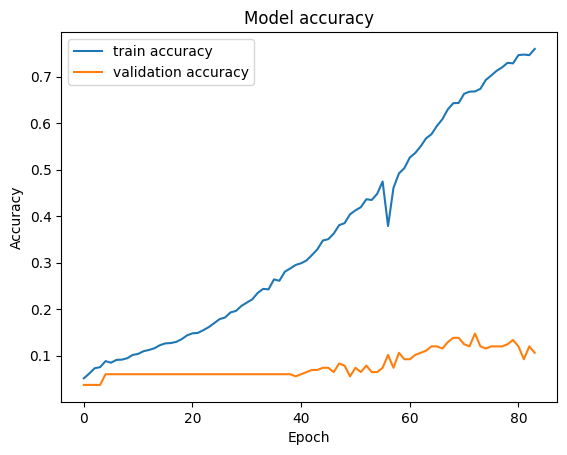

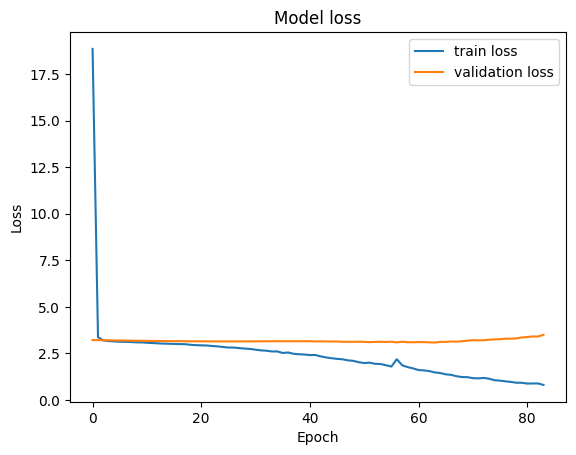

In [20]:
if best_history:
    plot_accuracy(best_history)
    plot_loss(best_history)
else:
    print("No history to plot")

In [21]:
keras.backend.clear_session()
print("Loading the model..")
best_model = keras.models.load_model(path_to_model)

if best_model is not None:
    print("Model loaded!")
    best_model: keras.models.Model
else:
    raise ValueError("Failed to load the model from the specified path.")

Loading the model..
Model loaded!


In [22]:
def display_confusion_matrix(real: list[int], predicted: list[int]):
    cmap = "viridis"
    cm_plot_labels = [i for i in range(25)]

    cm = metrics.confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm, cm_plot_labels, cm_plot_labels)
    sns.set(font_scale=1.1)
    plt.figure(figsize=(15, 10))
    s = sns.heatmap(df_cm, annot=True, cmap=cmap)
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.savefig("artifacts/metrics/confusion_matrix.png")
    plt.show()

20/20 [==============================] - 0s 6ms/step


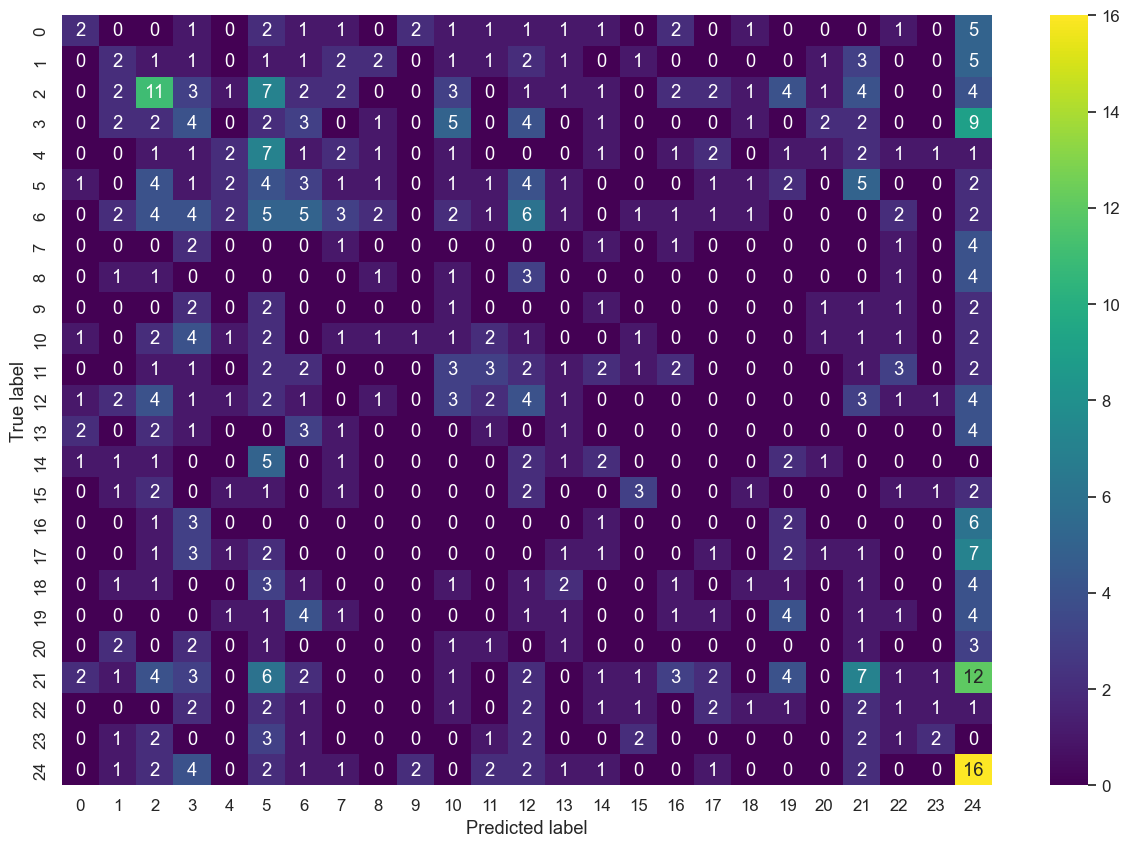

In [23]:
if best_model:
    Y_pred = best_model.predict(X_test)

    Y_pred_classes = np.argmax(Y_pred, axis=1)
    Y_true = np.argmax(Y_test, axis=1)

    display_confusion_matrix(Y_true, Y_pred_classes)
else:
    print("No best model found.")